In [1]:
import os
import re
import h5py
import random
import numpy as np
import pandas as pd
import scipy.io
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
datadir = '../../datasets/NNN/'
raster_data = pd.read_pickle(os.path.join(datadir, ('face_roi_data.pkl')))
print(f'data with these rois: {list(raster_data['roi'].unique())}')

data with these rois: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [ ]:
labels = pd.read_csv(os.path.join(datadir, 'shared1000_HED.tsv'), sep='\t')
targets = ['animal']

mask = labels["HED_short"].str.lower().apply(
    lambda x: all(t in x for t in targets) if isinstance(x, str) else False
)
to_idx = labels[mask].index.tolist()

metric = 'correlation'
roi = 'MO2_21_O' #'MF1_9_F'
PVALUE=0.05
roi_data = raster_data[(raster_data['roi']==roi) & (raster_data['p_value']<PVALUE)]
stacked = np.stack(roi_data['img_psth'])

substacked = stacked[:, :, to_idx]
# average over units
averaged = np.mean(substacked, axis=0)

fig,ax = plt.subplots(1,1)

rdm = squareform(pdist(averaged, metric=metric))
sns.heatmap(rdm, cmap=sns.color_palette('Greys_r', as_cmap=True), vmax=1.5)
ax.set_title(f'{roi}: {'.'.join(targets)}')

ax.axvline(x=50, color='red', linestyle='--', linewidth=1)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1)
plt.show()

In [ ]:
raster_data['session'].unique()

In [ ]:
single_units = raster_data[raster_data['unit_type']==1]
stacked = np.stack(single_units['img_psth'])
mean_per_unit = stacked.mean(axis=2)

df_long = pd.DataFrame(mean_per_unit).melt(var_name='time', value_name='response')
df_long['unit'] = np.repeat(np.arange(mean_per_unit.shape[0]), mean_per_unit.shape[1])

plt.subplots(1,1)
sns.lineplot(data=df_long, x='time', y='response', errorbar='sd', color='black')
plt.title('Single unit average time trace')
plt.tight_layout()
plt.show()

In [ ]:
roi = 'MO2_21_O' #'MF1_9_F'
roi_data = raster_data[(raster_data['roi']==roi)]

stacked = np.stack(roi_data['img_psth'])
averaged = np.mean(stacked, axis=0) # shape (450,1072)
df = pd.DataFrame(averaged)  # shape (450, 1072)
df_long = df.melt(var_name='image', value_name='response')
df_long['time'] = np.tile(np.arange(df.shape[0]), df.shape[1])



fig,ax=plt.subplots(1,1)
sns.lineplot(
    data=df_long, x='time', y='response',
    errorbar='sd',
    color='black',
    ax=ax
)
ax.axvline(x=50, color='red', linestyle='--', linewidth=1)
plt.title('Average PSTH')
plt.tight_layout()
plt.show()

In [ ]:
np.setdiff1d(np.arange(1000, 1072), np.concatenate([np.arange(1000,1024), np.arange(1025,1031), np.arange(1043,1049), np.arange(1051,1062)]))

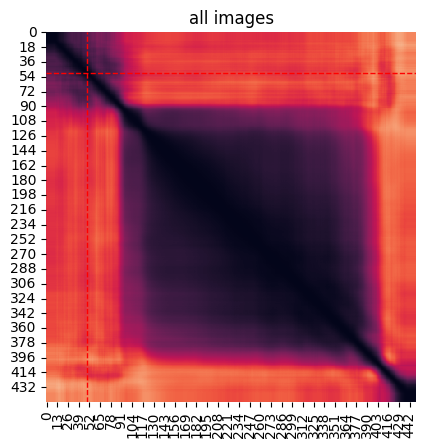

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


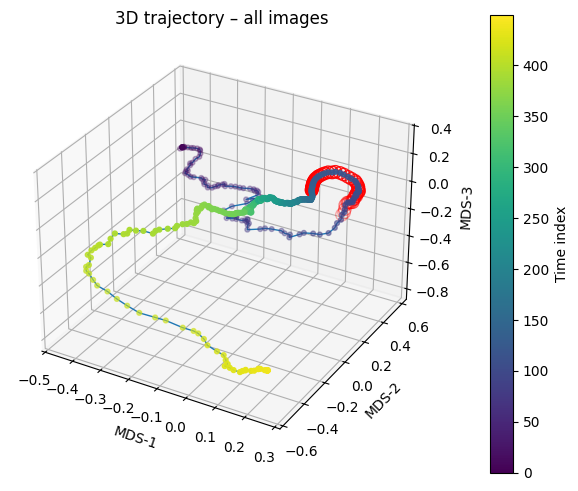

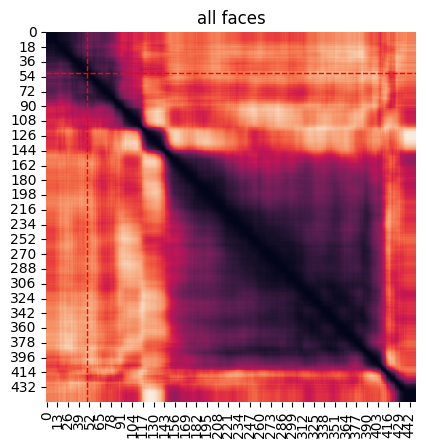

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


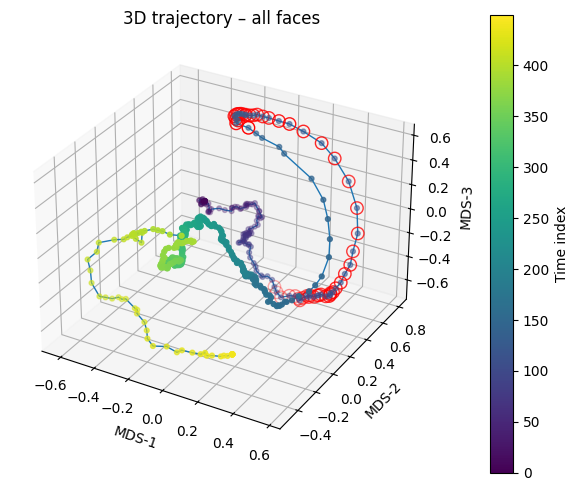

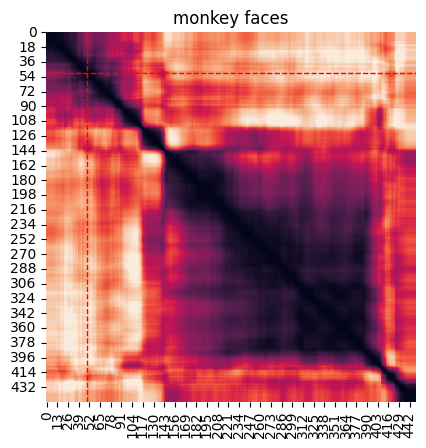

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


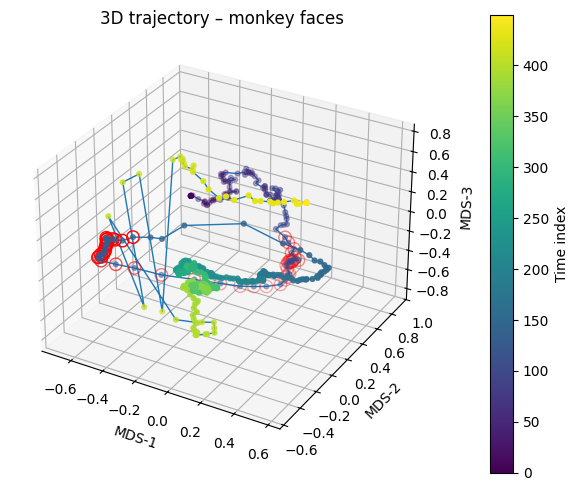

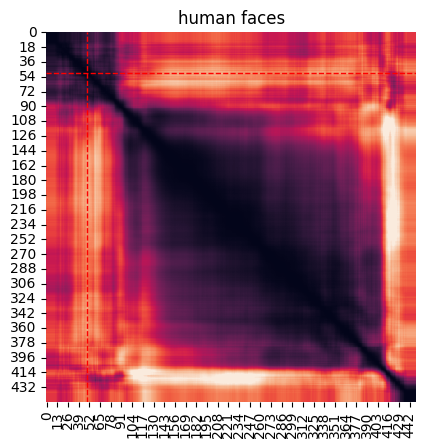

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


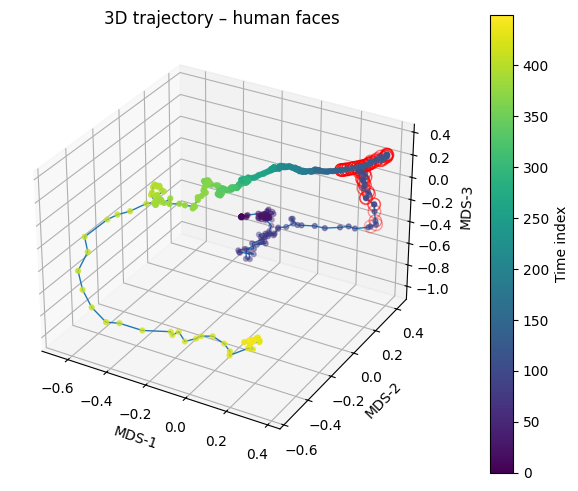

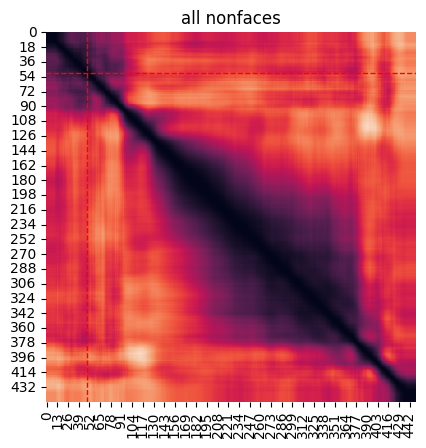

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


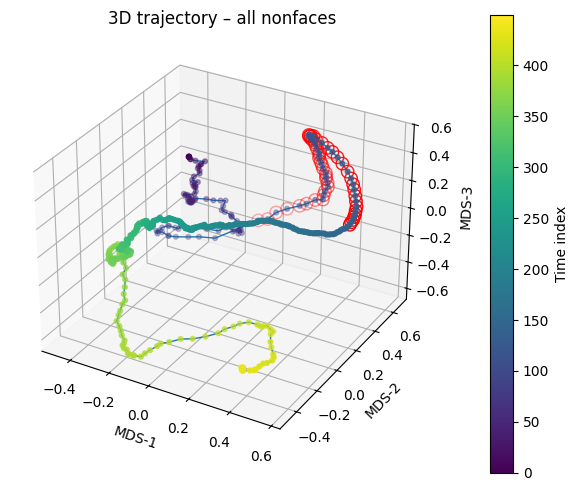

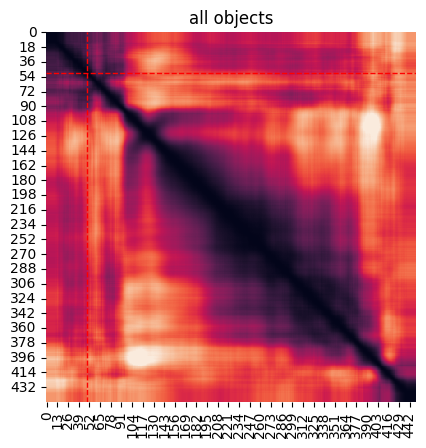

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


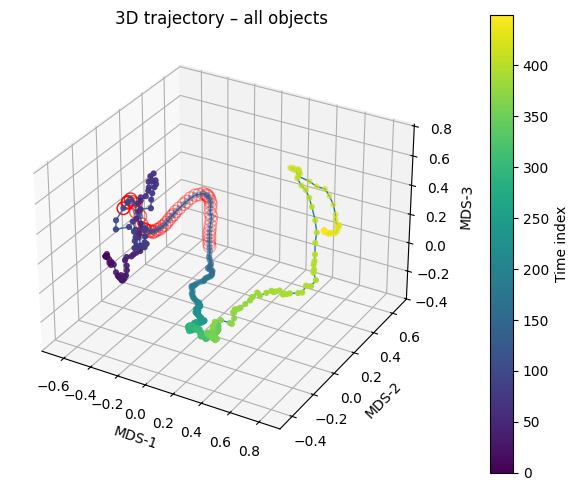

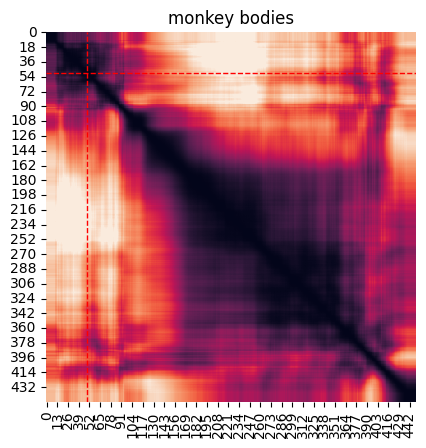

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


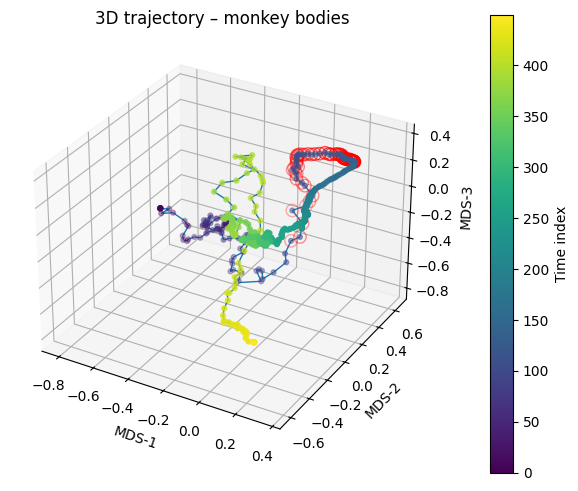

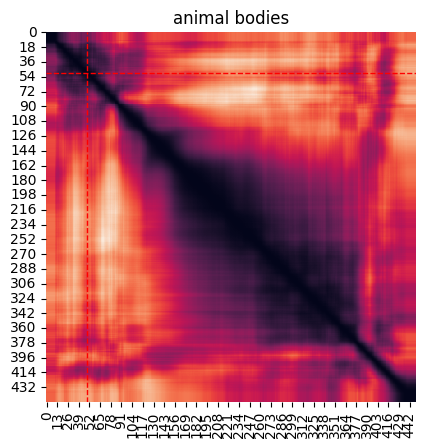

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


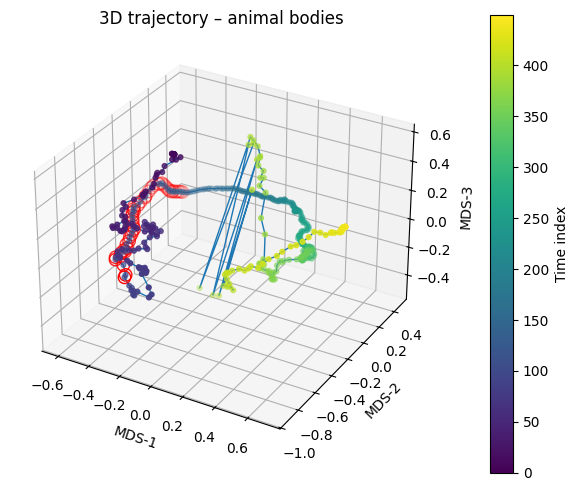

In [6]:
img_sets = {'all images': np.arange(1000,1072), 
           'all faces': np.arange(1000,1024),
           'monkey faces':  np.concatenate([np.arange(1000,1006), np.arange(1009,1016)]),
           'human faces': np.concatenate([np.arange(1006,1009), np.arange(1016,1025)]),
           'all nonfaces': np.arange(1025,1072),
            'all objects': np.setdiff1d(np.arange(1000, 1072), np.concatenate([np.arange(1000,1024), np.arange(1025,1031), np.arange(1043,1049), np.arange(1051,1062)])),
           'monkey bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049)]),
            'animal bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049), np.arange(1051,1062)]),
           }

# img_sets = {'all images': np.arange(1000,1072), 
#            'all nonfaces': np.arange(1025,1072),
#            'monkey bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049)]),
#            'animal bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049), np.arange(1051,1062)]),
#            'all objects': np.setdiff1d(np.arange(1000, 1072), np.concatenate([np.arange(1000,1024), np.arange(1025,1031), np.arange(1043,1049), np.arange(1051,1062)]))}

metric = 'correlation'
roi = 'MF1_8_F' #'MF1_9_F', MO1s1_4_O, MO2_21_O, MO1s1_4_O, AO2_24_O
PVALUE = 0.05
roi_data = raster_data[(raster_data['roi']==roi)& (raster_data['p_value']<PVALUE)]
stacked = np.stack(roi_data['img_psth'])

for k,v in img_sets.items():
    substacked = stacked[:, :, v]
    # average over units
    averaged = np.mean(substacked, axis=0)
    
    fig,ax = plt.subplots(1,1)

    # plot rdm
    rdm = squareform(pdist(averaged, metric=metric))
    sns.heatmap(rdm, cbar=False, square=True, vmax=1.5)
    ax.set_title(f'{k}')

    ax.axvline(x=50, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=50, color='red', linestyle='--', linewidth=1)
    plt.show()

    # Embed into 3D and plot trajectory
    mds = MDS(n_components=3, dissimilarity='precomputed', random_state=0)
    coords = mds.fit_transform(rdm)               # [time, 3]
    T = coords.shape[0]
    ts = np.arange(T)

    # 3D plot
    fig = plt.figure(figsize=(6,5))
    # ax = fig.add_subplot()
    ax = fig.add_subplot(111, projection='3d')

    # Draw trajectory line
    ax.plot(coords[:,0], coords[:,1], coords[:,2], 
            linewidth=1)

    # Scatter with time-coded colors
    sc = ax.scatter(coords[:,0], coords[:,1], coords[:,2],
                    c=ts, cmap='viridis', s=12)

    # Optional: highlight a particular time (e.g., 50)
    t_mark = np.arange(90, 140)
    if (t_mark < T).all:
        ax.scatter(coords[t_mark,0], coords[t_mark,1], coords[t_mark,2],
                   s=80, edgecolor='red', facecolor='none')

    ax.set_title(f"3D trajectory – {k}")
    ax.set_xlabel("MDS-1"); ax.set_ylabel("MDS-2"); ax.set_zlabel("MDS-3")
    cbar = plt.colorbar(sc, ax=ax, pad=0.1)
    cbar.set_label("Time index")

    plt.tight_layout()
    plt.show()

In [4]:
metric = 'correlation'
roi = 'MF1_8_F' #'MF1_9_F'
roi_data = raster_data[(raster_data['roi']==roi)]
stacked = np.stack(roi_data['img_psth'])

for k,v in img_sets.items():
    substacked = stacked[:, :, v]
    # average over units
    X = np.mean(substacked, axis=0)
    
    Xz = X - X.mean(axis=1, keepdims=True)
    Xz /= (np.linalg.norm(Xz, axis=1, keepdims=True) + 1e-8)
    pcaZ = PCA(n_components=3, random_state=0).fit(Xz)
    print(f"{k} - After demeaning+unit-norm EVR: {pcaZ.explained_variance_ratio_[:3]} | cumulative: {np.sum(pcaZ.explained_variance_ratio_[:3])}")
    coords = pcaZ.fit_transform(Xz)
    
#     # do pca on the data
#     pca = PCA(n_components=3, random_state=0)
#     coords = pca.fit_transform(averaged) 
    
    evr = pca.explained_variance_ratio_
    cum = evr.cumsum()
    print(f"{k} — EVR per comp: {np.round(evr, 3)} | cumulative: {np.round(cum, 3)}")

    T = coords.shape[0]
    ts = np.arange(T)

    # 3D plot
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')

    # Draw trajectory line
    ax.plot(coords[:,0], coords[:,1], coords[:,2], 
            linewidth=1)

    # Scatter with time-coded colors
    sc = ax.scatter(coords[:,0], coords[:,1], coords[:,2],
                    c=ts, cmap='viridis', s=12)

    # Optional: highlight a particular time (e.g., 50)
    t_mark = np.arange(90, 140)
    if (t_mark < T).all:
        ax.scatter(coords[t_mark,0], coords[t_mark,1], coords[t_mark,2],
                   s=80, edgecolor='red', facecolor='none')

    ax.set_title(f"3D trajectory – {k}")
    ax.set_xlabel("PC-1"); ax.set_ylabel("PC-2"); ax.set_zlabel("PC-3")
    cbar = plt.colorbar(sc, ax=ax, pad=0.1)
    cbar.set_label("Time index")

    plt.tight_layout()
    plt.show()

all images - After demeaning+unit-norm EVR: [0.38071743 0.20205165 0.10866901] | cumulative: 0.6914380788803101


NameError: name 'pca' is not defined

In [ ]:
from IPython.display import clear_output
import time

metric = 'correlation'
roi = 'MF1_7_F' #'MF1_9_F'
roi_data = raster_data[(raster_data['roi']==roi)]
stacked = np.stack(roi_data['img_psth'])

for i in range(200):
    fig, ax = plt.subplots(1,1)
    substacked = stacked[:, i, 1000:1024]
    rdm = squareform(pdist(substacked.T, metric=metric))
    sns.heatmap(rdm, cmap=sns.color_palette('Greys_r', as_cmap=True), vmax=0.75, ax=ax)
    ax.set_title(f't={i}')
    
    ax.axvline(x=15, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=15, color='red', linestyle='--', linewidth=1)
    ax.axvline(x=24, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=24, color='red', linestyle='--', linewidth=1)
    
    plt.show()
    time.sleep(0.01)
    clear_output(wait=True)

In [ ]:
savedir = '../gifs/localizer_set/'
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
metric = 'correlation'
    
roi = 'MF1_7_F' #'MF1_9_F'
roi_data = raster_data[(raster_data['roi']==roi)]
stacked = np.stack(roi_data['img_psth'])
    
for i in tqdm(range(200)):
    fig, ax = plt.subplots()
    substacked = stacked[:, i, 1000:1024]
    rdm = squareform(pdist(substacked.T, metric=metric))
    sns.heatmap(rdm, cmap=sns.color_palette('Greys_r', as_cmap=True), vmax=0.75, ax=ax)
    ax.set_title(f't={i}')
    plt.tight_layout()
    plt.savefig(os.path.join(savedir,f'frame_{i:03d}.png'), dpi=300, transparent=False, bbox_inches='tight')
    plt.close(fig)
    
print('done')

In [ ]:
img_sets = {'all images': np.arange(1000,1072), 
           'all faces': np.arange(1000,1024),
           'monkey faces':  np.concatenate([np.arange(1000,1006), np.arange(1009,1016)]),
           'human faces': np.concatenate([np.arange(1006,1009), np.arange(1016,1025)]),
           'all nonfaces': np.arange(1025,1072),
            'all objects': np.setdiff1d(np.arange(1000, 1072), np.concatenate([np.arange(1000,1024), np.arange(1025,1031), np.arange(1043,1049), np.arange(1051,1062)])),
           'monkey bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049)]),
            'animal bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049), np.arange(1051,1062)]),
           }

metric = 'correlation'
roi = 'MF1_8_F' #'MF1_9_F'
roi_data = raster_data[(raster_data['roi']==roi) & (raster_data['p_value']<0.05)]
stacked = np.stack(roi_data['img_psth'])

k = 'all images'
v = img_sets[k]

In [ ]:
img_stack = stacked[:, :, v]
fig, axes = plt.subplots(5, 10, figsize=(20, 20))
axes = axes.ravel()
for it, t in enumerate(range(100, 150)):
    ax = axes[it]
    ui = img_stack[:, t, :]
    rdv = pdist(ui.T, metric='correlation')
    rdm = squareform(rdv)
    sns.heatmap(rdm, square=True, ax=ax, cbar=False)
    ax.set_axis_off()
plt.show()

In [ ]:
for k, v in img_sets.items():
    img_stack = stacked[:, :, v]
    # ui = img_stack[:, t, :]
    # rdv = pdist(ui.T, metric='correlation')
    rdvs = np.array([pdist(img_stack[:, t, :].T, metric='correlation') for t in range(img_stack.shape[1])])
    tixti = squareform(pdist(rdvs, metric='correlation'))
    
    fig,ax = plt.subplots(1,1)
    sns.heatmap(tixti, square=True, cbar=False, ax=ax)
    ax.set_title(k)
    ax.set_axis_off()
    plt.show()

In [ ]:
def rdv_redo(X, mode='top', step=5, k_max=200, metric='correlation',
                 onset=50, resp=(50,220), base=(-50,0), random_state=0):
    rng = np.random.default_rng(random_state)
    ONSET = onset
    RESP = slice(ONSET + resp[0], ONSET + resp[1])
    BASE = slice(ONSET + base[0], ONSET + base[1])

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # choose the image-set bins to calculate RDMs
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    # sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    rdvs = []
    for k in tqdm(sizes):
        idx = order[:k]
        Ximg = X[:, :, idx] # (units, time, images)
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        R = pdist(Xrdv, metric=metric)   # (time, time)
        rdvs.append(R)
    return sizes, rdvs

In [ ]:
roi = 'Unknown_19_F' #'MF1_9_F', Unknown_19_F, MF1_8_F
roi_data = raster_data[(raster_data['roi']==roi) & (raster_data['p_value']<0.05)]
stacked = np.stack(roi_data['img_psth'])

sizes, rdvs = rdv_redo(stacked, mode='top', step=1, k_max=100, metric='correlation')
for i, rdv in enumerate(rdvs):
    rdm = squareform(rdv)
    fig,ax=plt.subplots(1,1)
    sns.heatmap(rdm, square=True, cbar=False, ax=ax)
    ax.set_axis_off()
    ax.set_title(sizes[i])
    plt.show()